# Excel Workbook Analysis of Margin Call Value at Risk for Futures Contracts

## Background

Below I run an Excel workbook simulation in Python, using a worksheet borrowed from the Financial Engineering and Risk Management course provided by professors Martin Haugh and Garud Iyengar of the Industrial Engineering and Operations Research department at Columbia University. The margin calls on the worksheet titled `Simulated data` is based on simulated profits and losses (P&L) for corn futures.

Computing the P&L follows a simple formula, namely:
$$
    P_t = n_\text{pos}\times (P_t - P_{t-1})\times \frac{c}{100}
$$

where $n_\text{pos}$ is the number of outstanding positions in the portfolio and $c$ is the value of the contract (i.e., market value for a single bushel of corn). The vested target has a margin call whenever losses fall below the maintenance margin, in which case, the margin account is reset to the initial margin, and the vested target is expected to pay the difference in order for the margin account to return to initial margin.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywin32_bootstrap, pywin32_system32, pywin32_testutil
import win32com.client

## First Section of the Analysis

### In case I need to do something in Excel from within Python...

```
from openpyxl import Workbook as wb, load_workbook

workbook = load_workbook(filename='C://Users//salma//Documents//Economics//Financial Economics//Financial Engineering//Columbia Course//Part I/Week3//cornfutures - swaptures.xlsx', read_only=True, data_only=True)

workbook['Sheet1']

wb_data = pd.ExcelFile(file)
ws_data = pd.read_excel(wb_data, index_col=None, na_values=['NA'], sheet_name='Simulated data')
ws_
ws_data.iloc[11:25, 6]
```

### The Workbook and Worksheet I need...

In [2]:
file_name = 'cornfutures - swaptures.xlsx'
file_path = 'C:\\Users\\salma\\Documents\\Economics\\Financial Economics\\Financial Engineering\\Columbia Course\\Part I\\Week3\\'

I begin by loading the Excel workbook into Python, where the `contract_value`, `initial_margin` of the margin account and `maintenance_margin`, required as per the contract with a broker dealer, are as follows.

In [3]:
xl = win32com.client.DispatchEx('Excel.Application')
wb = xl.workbooks.open(file_path+file_name)

contract_value = wb.Sheets(2).Cells(3, 3).Value
initial_margin = wb.Sheets(2).Cells(4, 3).Value
maintenance_margin = wb.Sheets(2).Cells(5, 3).Value

d = {'Contract Value': contract_value,
     'Initial Margin': initial_margin,
     'Maintenance Margin': maintenance_margin}; d

{'Contract Value': 5000.0,
 'Initial Margin': 1688.0,
 'Maintenance Margin': 1250.0}

### Point Estimate and Standard Error

For the point estimates, I have the average value of the sampling distribution, which later I will use to calculate a corresponding Gosset t-statistic. The average value of a sampling distribution estimates its first order moment, such as mean, median or mode for a univariate parameter or mean differences and correlation for a bivariate or multivariate parameter. The point estimate is

$$^{t}\hat{\Theta}_i$$

where $t$ denotes a $t$-distributed variable, with an unknown population mean and population variance. There are four point estimates I will be taking beneath. One is for the average value of a margin call `x`, a second point estimate is for the average value of the standard deviation of margin call `s` and I take a third point estimate for the logarithmic returns in the margin account for the date range highlighted in the spreadsheet (between `Feb 22nd` and `March 15th`. There is a fourth point estimate for the standard deviation of the logirithmic returns.

The standard error of the mean $\mu$ is the standard deviation of the sampling distribution, but it is not the standard deviation of $\mu$, which could still be approximated, and the standard deviation is needed for coming up with confidence intervals. In fact, for sampling distributions $\mu$ (`x`), `log_r` (`r`),  $\sigma$ (`s`) and $\phi$ (`u`), I have point estimates and standard errors:

In [4]:
μ = []
σ = []
ϕ = []

log_r = []
for i in range(0, 1000):
    wb.Sheets(2).Calculate()
    single_trial = [wb.Sheets(2).Cells(i, 7).Value for i in range(13, 28)]

    log_rr = []
    for j, x in enumerate(single_trial):
        if j > 0:
            log_rr.append((1-np.log(1+x)) - (1-np.log(1+single_trial[j-1])))

    n = len(single_trial)
    
    μ.append(np.sum(single_trial) / n)
    σ.append(np.std(single_trial) / np.sqrt(n))
    
    log_r.append(np.sum(log_rr) / n)
    ϕ.append(np.std(log_rr) / np.sqrt(n))

x = np.sum(μ) / len(μ)
r = np.sum(log_r) / len(log_r)

s = np.sum(σ) / len(σ)
u = np.sum(ϕ) / len(ϕ)

x, r, s, u

(129.25432566922714,
 0.08604252613851335,
 70.14857888313949,
 0.6463242202708768)

$\bar{X}$ "could" be used as the **point estimate** for the first order mean, and $s$ as the point estimate for the standard deviation of the sample, which is derived from a second order moment known as the sample variance, herein obtained via $1,000$ single trials of $15$ observations each. Note that the square root of the sample variance ($s^2$) is not the standard deviation of the sampling distribution of the first order mean. All sampling distributions of the first order parameters have point estimates and standard errors as follows.

In [5]:
df = np.transpose(
    pd.DataFrame({
        'x': [x],
        'r': [r],
        's': [s],
        'u': [u]
})); df.rename(columns={0: 'point estimate'}, inplace=True);

df['standard error'] = [np.std(μ)/np.sqrt(len(μ)),
                        np.std(log_r)/np.sqrt(len(log_r)),
                        np.std(σ)/np.sqrt(len(σ)),
                        np.std(ϕ)/np.sqrt(len(ϕ))]

In [6]:
df

,point estimate,standard error
x,129.254326,3.807615
r,0.086043,0.007776
s,70.148579,1.524075
u,0.646324,0.012843


### Function for Computing Point Estimates and Standard Errors

From here onward, I will be using the following function for returning the sampling distributions of $\mu$, `log_r`, $\sigma$ and $\phi$.

In [7]:
def b():
    μ = []
    σ = []
    ϕ = []
    
    log_r = []
    for i in range(0, 1000):
        wb.Sheets(2).Calculate()
        single_trial = [wb.Sheets(2).Cells(i, 7).Value for i in range(13, 28)]
    
        log_rr = []
        for j, x in enumerate(single_trial):
            if j > 0:
                log_rr.append((1-np.log(1+x)) - (1-np.log(1+single_trial[j-1])))
    
        n = len(single_trial)
        
        μ.append(np.sum(single_trial) / n)
        σ.append(np.std(single_trial) / np.sqrt(n))
        
        log_r.append(np.sum(log_rr) / n)
        ϕ.append(np.std(log_rr) / np.sqrt(n))
    
    x = np.sum(μ) / len(μ)
    r = np.sum(log_r) / len(log_r)
    
    s = np.sum(σ) / len(σ)
    u = np.sum(ϕ) / len(ϕ)
    
    df = np.transpose(
        pd.DataFrame({
            'x': [x],
            'r': [r],
            's': [s],
            'u': [u]
    })); df.rename(columns={0: 'point estimate'}, inplace=True);
    
    df['standard error'] = [np.std(μ)/np.sqrt(len(μ)),
                            np.std(log_r)/np.sqrt(len(log_r)),
                            np.std(σ)/np.sqrt(len(σ)),
                            np.std(ϕ)/np.sqrt(len(ϕ))]
    
    return μ, log_r, σ, ϕ, df

### Function for the Shape of the PDF and CDF: $μ$ and $σ$

What does the shape of the sampling distribution look like. What about the cummulative distribution?

In [8]:
def d(μ, σ):
    fig, axs = plt.subplots(2, 3)
    axs[0, 0].hist(μ); axs[0, 0].set_title('μ pdf')
    axs[0, 1].hist(μ, cumulative=True); axs[0, 1].set_title('μ cdf')
    axs[0, 2].boxplot(μ); axs[0, 2].set_title('μ boxplot')
    axs[1, 0].hist(σ); axs[1, 0].set_title('σ pdf')
    axs[1, 1].hist(σ, cumulative=True); axs[1, 1].set_title('σ cdf')
    axs[1, 2].boxplot(σ); axs[1, 2].set_title('σ boxplot')
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    fig.set_size_inches(14, 9)

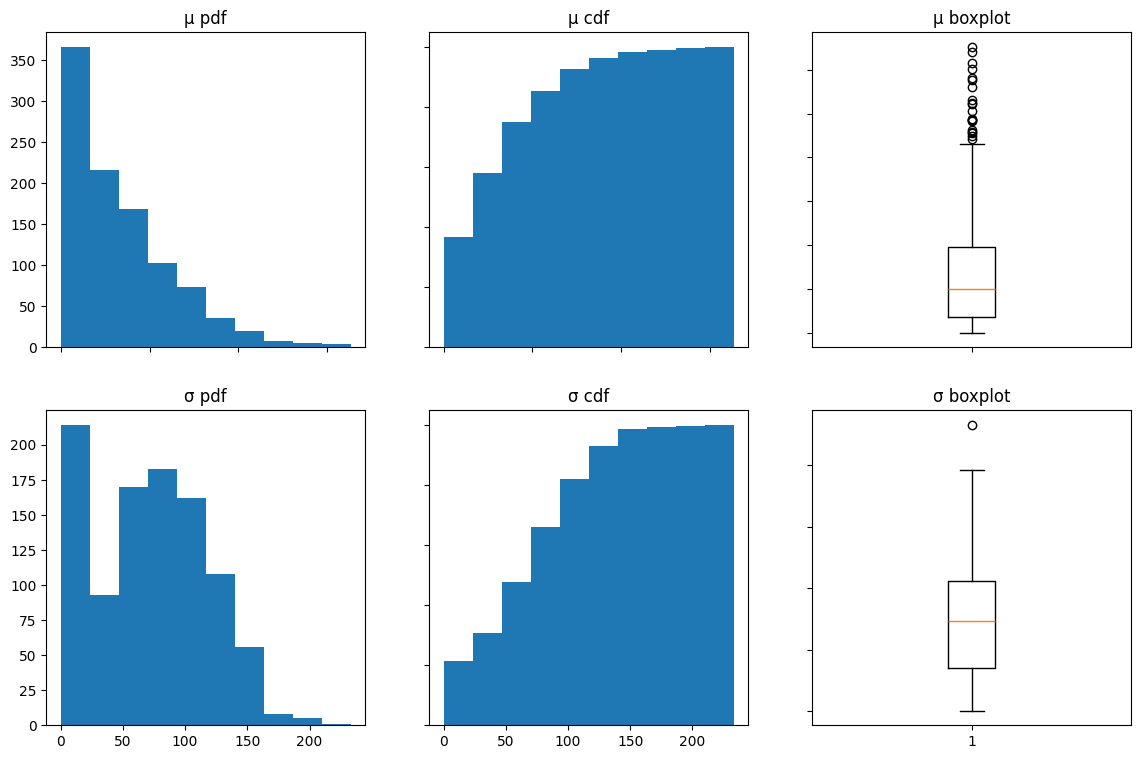

In [9]:
d(μ, σ)

Note that we still have a problem with using $\mu$ and $\sigma$ as plotted above, and this has to do with outliers. Removing the oultiers is necessary for coming up with better estimates for first and higher order statistical moments.

### Function for Drawing Boxplots (Separately) and a Closer Look at Outliers

Before performing any transformation or doing any computations on the data, I need to draw a boxplot, computationally determine the Interquartile Range (IQR) for each of the first order moments, including returns on the margin calls for broker-dealers (labeled `r`), and what each parameter $^t\hat\Theta_i$ is, to remove outliers from the sampling distributions. My boxplots are determined by function `o` below,

In [10]:
def o(μ, log_r, σ, ϕ):
    fig = plt.figure(1, figsize=(0.6*20, 0.4*20))
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    
    ax1.boxplot(μ); ax1.set_title('μ boxplot')
    ax2.boxplot(log_r); ax2.set_title('r boxplot')
    ax3.boxplot(σ); ax3.set_title('σ boxplot')
    ax4.boxplot(ϕ); ax4.set_title('ϕ boxplot')

which can be ran to determine outliers  for $μ$, `log_r`. $\sigma$ and $\phi$

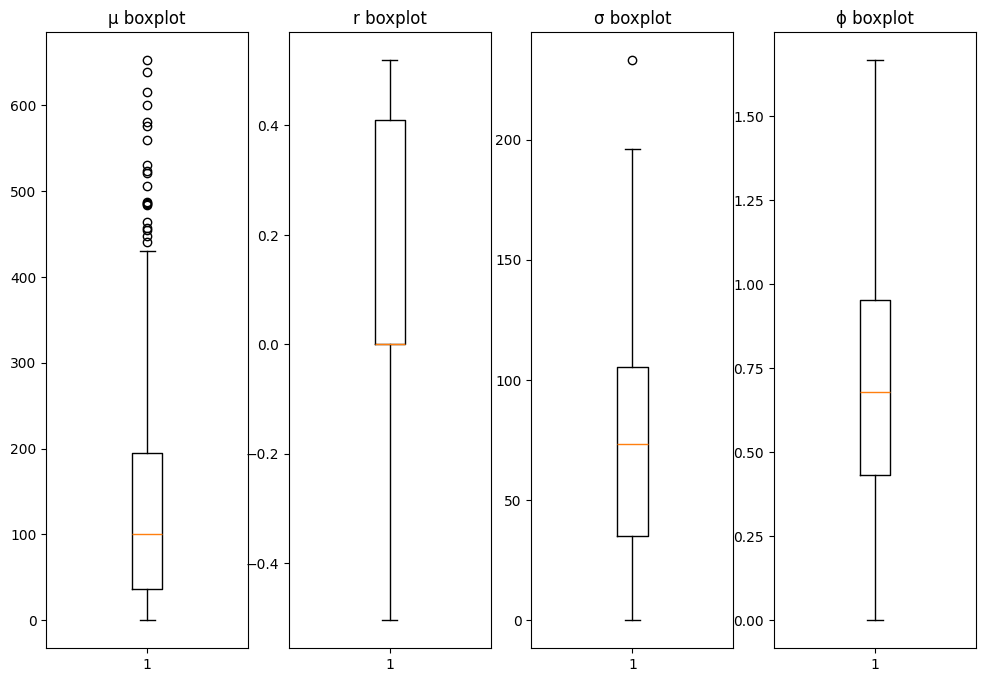

In [11]:
o(μ, log_r, σ, ϕ)

The sampling distributions of each first order moment has varying skewness. There is a problem with the parameter selection for `xrsu`. I will take a Winsorized mean, to determine the `IQR` of each first order moment, as follows.

In [12]:
q1_μ = np.percentile(μ, 25, method='midpoint')
q3_μ = np.percentile(μ, 75, method='midpoint')

q1_r = np.percentile(log_r, 25, method='midpoint')
q3_r = np.percentile(log_r, 75, method='midpoint')

q1_σ = np.percentile(σ, 25, method='midpoint')
q3_σ = np.percentile(σ, 75, method='midpoint')

q1_ϕ = np.percentile(ϕ, 25, method='midpoint')
q3_ϕ = np.percentile(ϕ, 75, method='midpoint')

iqr_μ = q3_μ-q1_μ;
iqr_r = q3_r-q1_r;
iqr_σ = q3_σ-q1_σ;
iqr_ϕ = q3_ϕ-q1_ϕ;

iqr_μ, iqr_r, iqr_σ, iqr_ϕ

(159.23495513956712, 0.4097957336129739, 70.47209432096975, 0.5222317568376954)

which gives me a value range of

$$^t\hat{\Theta}_i \pm 1.5 * \text{IQR}$$

for $\mu$, `log_r`, $\sigma$ and $\phi$, as determined above.

I am only interested in the positive values for `μ`, `σ` and $\phi$, since these cannot be negative, but I am interested in both positive and negative values for `log_r`, because log returns can be positive or negative. This simplifies the procedure for getting Winsorized first order moments, which as per the following algorithm

In [13]:
outliers_μ = (x - 1.5*iqr_μ, x + 1.5*iqr_μ)
outliers_r = (r - 1.5*iqr_r, r + 1.5*iqr_r)
outliers_σ = (s - 1.5*iqr_σ, s + 1.5*iqr_σ)
outliers_ϕ = (u - 1.5*iqr_ϕ, u + 1.5*iqr_ϕ)

for i, each in enumerate(μ):
    if each < outliers_μ[0]:
        μ[i] = outliers_μ[0]
    if each > outliers_μ[1]:
        μ[i] = outliers_μ[1]

for i, each in enumerate(log_r):
    if each < outliers_r[0]:
        log_r[i] = outliers_r[0]
    if each > outliers_r[1]:
        log_r[i] = outliers_r[1]

for i, each in enumerate(σ):
    if each < outliers_σ[0]:
        σ[i] = outliers_σ[0]
    if each > outliers_σ[1]:
        σ[i] = outliers_σ[1]

for i, each in enumerate(ϕ):
    if each < outliers_ϕ[0]:
        ϕ[i] = outliers_ϕ[0]
    if each > outliers_ϕ[1]:
        ϕ[i] = outliers_ϕ[1]

would generate the following box and whisker plots.

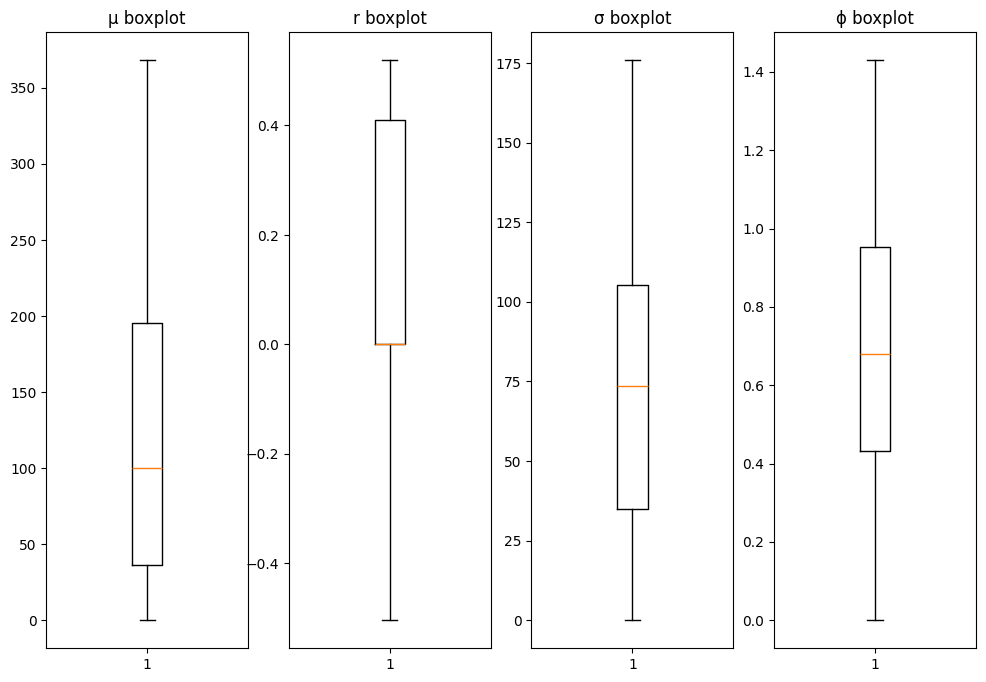

In [14]:
o(μ, log_r, σ, ϕ)

## Second Section of the Analysis

Before I continue, I need to reevaluate the *Winsorized* parameters for $xrsu$.

In [15]:
x = np.sum(μ) / len(μ)
r = np.sum(log_r) / len(log_r)
s = np.sum(σ) / len(σ)
u = np.sum(ϕ) / len(ϕ)

x, r, s, u

(125.32581014918449,
 0.08604252613851335,
 70.00566733098408,
 0.6459290969858944)

Considering the center of distribution based on the median (50th percentile), the margin calls resemble some sort of positive skewness for both `μ` and `σ`, but this is still conformal with what is expended based on the central limit theorem, where the sampling distribution for first other moment $\hat{^t\Theta_i}$ of t-statistic $t_i$ becomes normally distributed as the number of observations tend to infinity ($n \rightarrow \infty$).

I may safely proceed with the following plots:

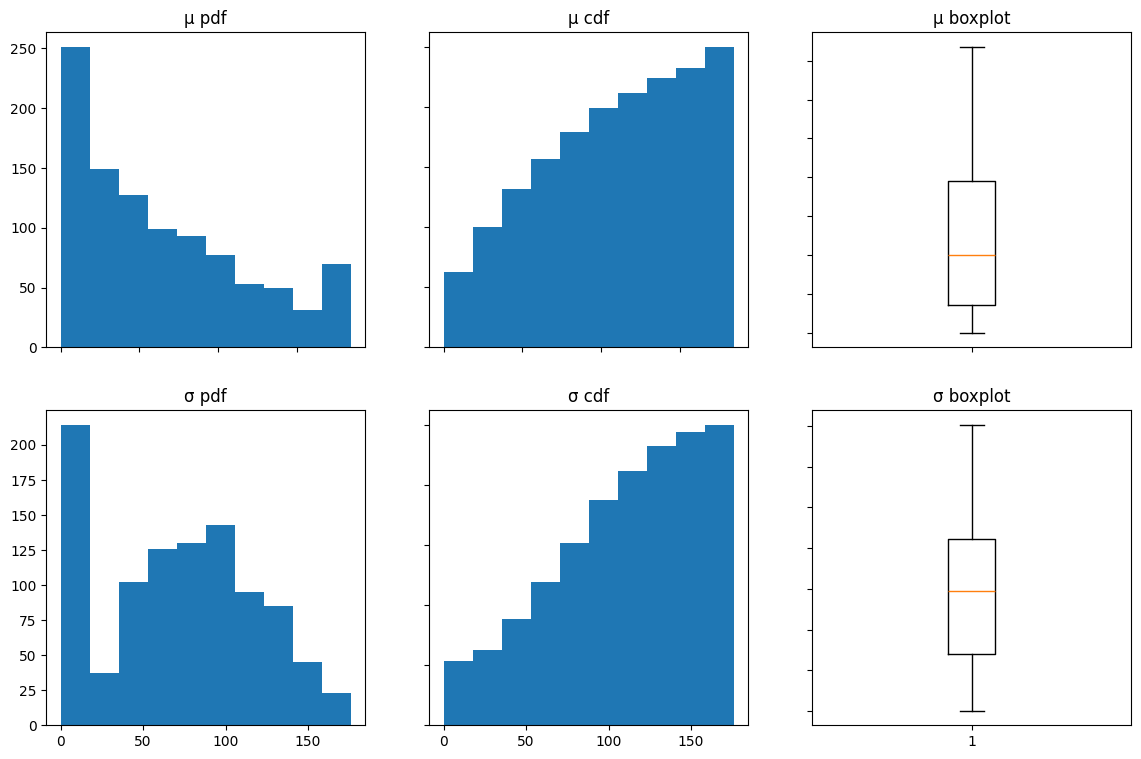

In [16]:
d(μ, σ)

with central tendency relation: $\text{Mode} \leq \text{Median} \leq \text{Mean}$, due to positive skewness. The numeric value for $\mu$ is

In [17]:
np.mean(μ)

125.32581014918449

and the numeric value for the median is

In [18]:
np.median(μ)

100.25023344119273

although I could not find one for the mode without having to build an algorithm for it. I have it that the mode is the most frequent value in the distribution or a value $v \in [0, 17]$ for $\mu$ and $\sigma$.

### Reliability Factors

T values found [here](https://www.tdistributiontable.com/).

$$t_{\alpha}\text{ or }z_{\alpha}$$

The reliability factor is equivalent to the kernel density score used to compute confidence intervals. For my analysis, I am considering reliability factors for the `90%`, `95%`, `97.5%` and the `99%` confidence intervals for $\text{df} = n-1 = 14$ degrees of freedom on a Gosset t-statistic.

In [19]:
conf_int = ['90%', '95%', '97.5%', '99%']
conf_int_values = ['1.345', '1.761', '2.145', '2.624']

c_ints = {'conf_int': conf_int, 'conf_int_values': conf_int_values}

rf = pd.DataFrame(c_ints)
rf

,conf_int,conf_int_values
0,90%,1.345
1,95%,1.761
2,97.5%,2.145
3,99%,2.624


Here I am using the $97.5\%$ confidence level, for $\alpha = 5\%$ and $\frac{\alpha}{2} = 2.5\%$. 

### Standard Error

Earlier, it was determined that the standard error would be a value

$$\text{SE} = \frac{s}{\sqrt{n}}$$

or

In [20]:
s = np.std(μ)
se_x = s / np.sqrt(len(μ))

s = np.std(log_r)
se_r = s / np.sqrt(len(log_r))

s = np.std(σ)
se_s = s / np.sqrt(len(σ))

s = np.std(ϕ)
se_u = s / np.sqrt(len(ϕ))

df = np.transpose(
    pd.DataFrame({'se_μ': [se_x], 'se_r': [se_r], 'se_σ': [se_s], 'se_ϕ': [se_u]})
); df.rename(columns={0: 'standard errors'}, inplace=True); df

,standard errors
se_μ,3.463395
se_r,0.007776
se_σ,1.512572
se_ϕ,0.012816


although I am using `se_r` for this example.

### Confidence Interval

Putting it all together, I have

$$\text{CI} = \text{PE} \pm \text{RF}\times \text{SE}$$
$$\text{CI} = \bar{X} \pm t_{\alpha/2}\times\frac{s}{\sqrt{n}}$$

where $s$ is equal to the sampling distribution of $\phi$, the standard deviation of the returns, as a first order moment, and $n$ is the number of observations in the sampling distribution of $\phi$, 

In [21]:
ci = (r-float(rf['conf_int_values'][2])*se_r, r+float(rf['conf_int_values'][2])*se_r)
ci

(0.06936251040157126, 0.10272254187545543)

### 5% Value-at-Risk (VaR) [Parametric Method]

Suppose $\$5,000$ is deposited, or the full contract value of a single position in the underlying commodity (corn, in this case). How much of these $\$5,000$ is put at risk by using futures contract, with initial margin $\$1,688$ and maintenance margin $\$1,250$?

In [22]:
5000*(r+se_r*float(rf['conf_int_values'][1]))

498.6823456407136

As can be seen, the value at risk is small compared to the $\$5,000$ contract value or even the $\$1,688$ required in a margin account by the broker. In the below section, I extend the single position contract into a contract involving incremental positions.

## Third Section of the Analysis

In this third section of the analysis, I will be studying the value at risk for various positions on a single commodity, namely, bushels of corn, where according to the exercise, one bushel of corn has a contract value of $5,000$ and $\frac{\text{no}}{100}$ dollars. I will be incrementally increasing the positions, to model a corn trader taking the decision to buy extra bushels of corn (up to 10 at a time) or hold the current position, based on the binomial variabnle $X \sim \text{Bin}(n, p)$ with probability mass function

$$
    f(k, n, p) = P(k; n, p) = Pr(X = k) = \binom{n}{k}p^k(1 - p)^{n - k}
$$

and cummulative distribution function

$$
    F(r; k \leq r \leq n) = \sum_{k=0}^{r} \binom{n}{k}p^k(1 - p)^{n - k}
$$

where I am sampling using the following probability vector for the position increments, starting at $1$ for day $1$, over $14$ days

$$
    P = \frac{1}{100}(37, 19, 17, 11, 7, 1.7, 1.5, 1.5, 1.3, 1.2, 1.0, 0.7, 0.07, 0.03)^t
$$

which, after taking these increments, gives me the following asset positions.

In [23]:
pos = [1]
countdown = 14

probs = np.random.binomial(n=10, p=(1/100)*np.transpose([37, 19, 17, 11, 7, 1.7, 1.5, 1.5, 1.3, 1.2, 1.0, 0.7, 0.07, 0.03]))

i = 1
while countdown > 0:
    countdown -= 1
    pos.append(pos[i-1] + probs[i-1]); i += 1

pos

[1, 2, 3, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

Now to do the fun part, which is to modify the worksheet, using a "buy and hold" strategy for each new positions obtained during the $15$ consecutive days.

In [24]:
for i, x in enumerate(range(12, 27)):
    wb.Sheets(2).Cells(x, 4).Value = pos[i]

Once again, here are the sampling distributions of $μ$, `log_r` and $σ$ as well as $\phi$, their respective point estimates and standard errors:

In [25]:
μ, log_r, σ, ϕ, df = b(); df

,point estimate,standard error
x,1191.412158,20.986411
r,0.420896,0.005860
s,527.089412,6.256045
u,1.119515,0.010600


Here are replotted graphics for the boxplots.

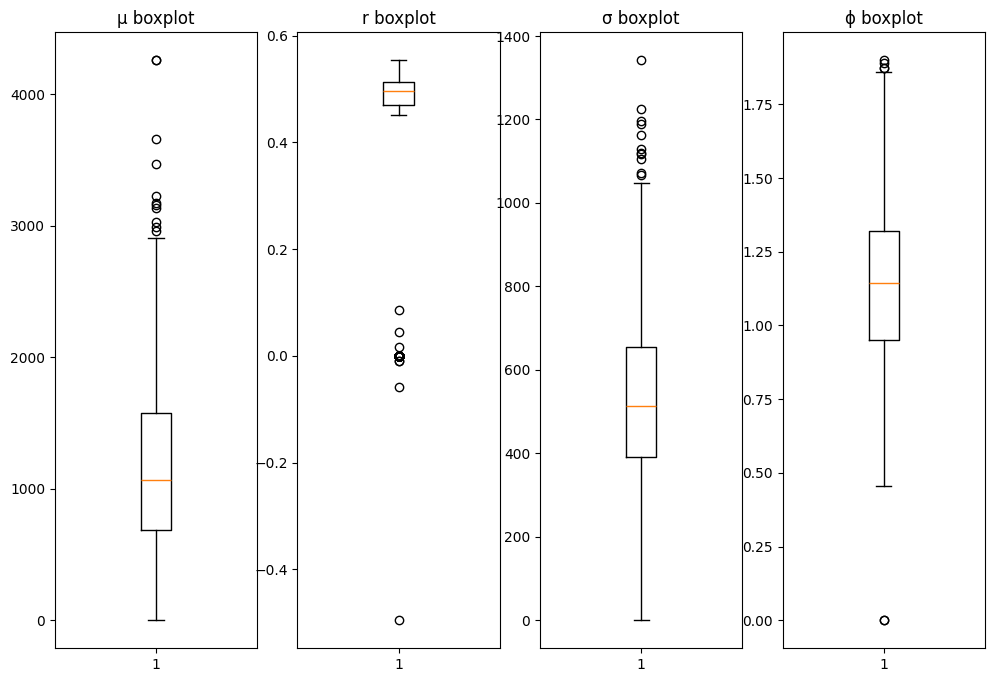

In [26]:
o(μ, log_r, σ, ϕ)

In this particular case, there are more outliers, as would be expected from incrementally adding positions to the existing portfolio. If I wanted to deal with the outliers, I can do as before, although I would like for the reader to take note of the fact that the boxplot of margin call returns to the broker has negative skewness, with many outliers, unlike before. I can remove the outliers once again,

In [37]:
q1_μ = np.percentile(μ, 25, method='midpoint')
q3_μ = np.percentile(μ, 75, method='midpoint')

q1_σ = np.percentile(σ, 25, method='midpoint')
q3_σ = np.percentile(σ, 75, method='midpoint')

q1_r = np.percentile(log_r, 25, method='midpoint')
q3_r = np.percentile(log_r, 75, method='midpoint')

iqr_μ = q3_μ-q1_μ;
iqr_σ = q3_σ-q1_σ;
iqr_r = q3_r-q1_r;

outliers_μ = (x - 1.5*iqr_μ, x + 1.5*iqr_μ)
outliers_σ = (s - 1.5*iqr_σ, s + 1.5*iqr_σ)
outliers_r = (r - 1.5*iqr_r, r + 1.5*iqr_r)

for i, each in enumerate(μ):
    if each < outliers_μ[0]:
        μ[i] = outliers_μ[0]
    if each > outliers_μ[1]:
        μ[i] = outliers_μ[1]

for i, each in enumerate(log_r):
    if each < outliers_r[0]:
        log_r[i] = outliers_r[0]
    if each > outliers_r[1]:
        log_r[i] = outliers_r[1]

for i, each in enumerate(σ):
    if each < outliers_σ[0]:
        σ[i] = outliers_σ[0]
    if each > outliers_σ[1]:
        σ[i] = outliers_σ[1]

for i, each in enumerate(ϕ):
    if each < outliers_ϕ[0]:
        ϕ[i] = outliers_ϕ[0]
    if each > outliers_ϕ[1]:
        ϕ[i] = outliers_ϕ[1]

thereby resulting in the following histograms and boxplots for $\mu$ and $\sigma$,

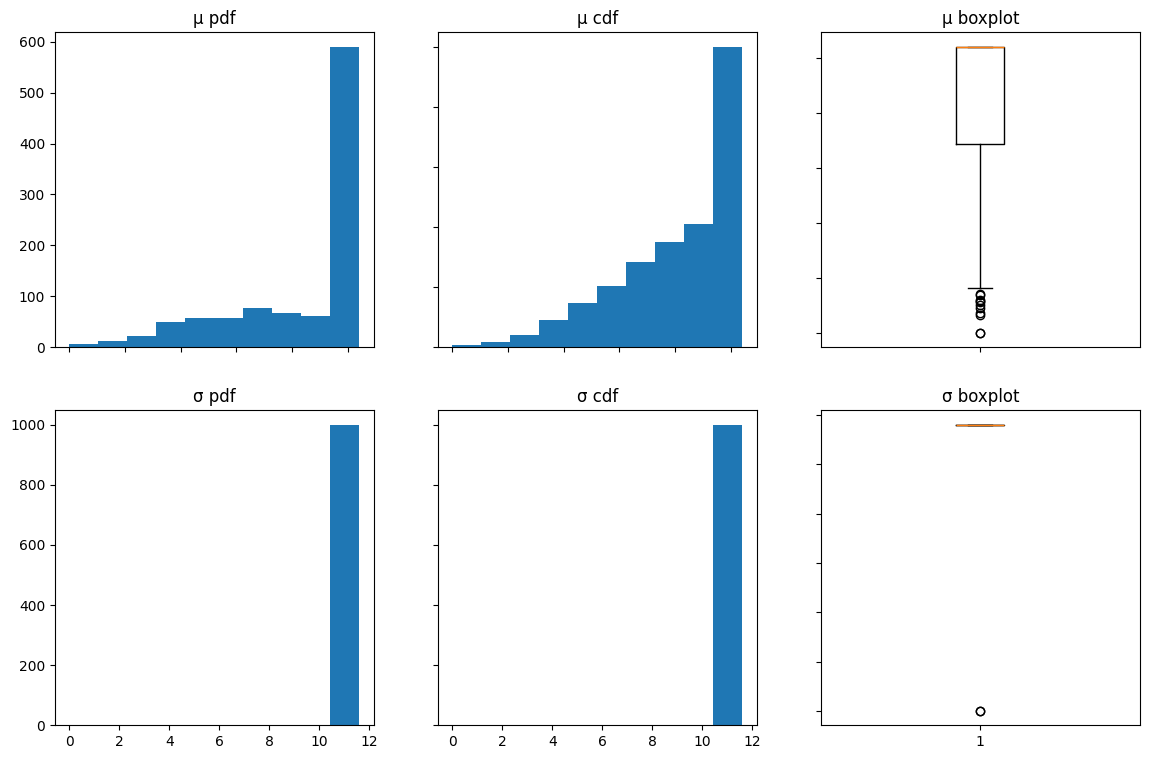

In [38]:
d(μ, σ)

and boxplots for all first order moments brought together.

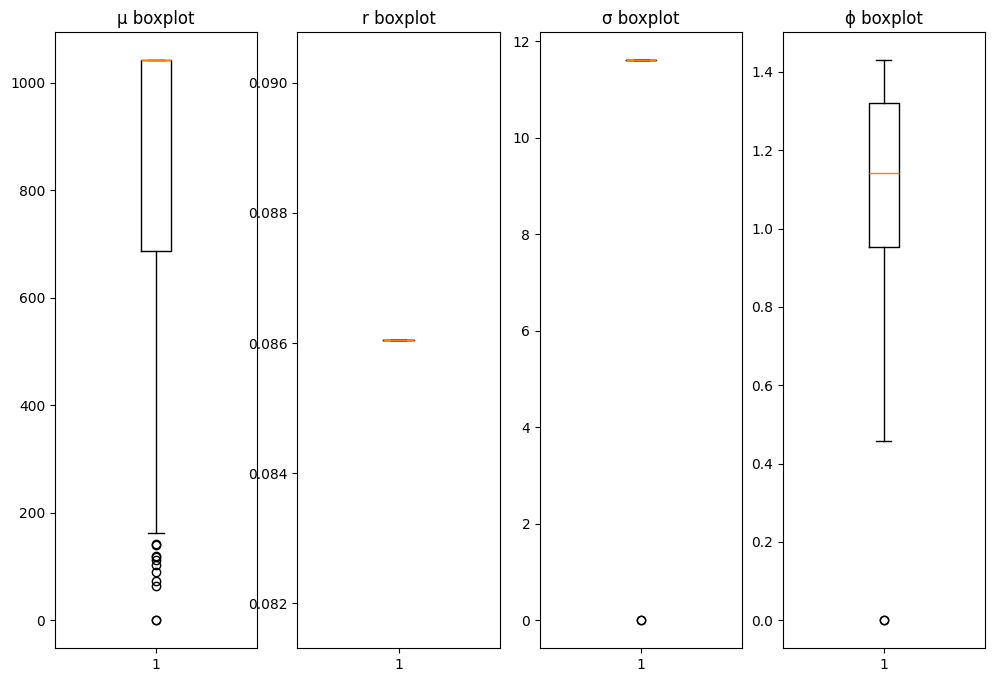

In [39]:
o(μ, log_r, σ, ϕ)

### Hypothesis Testing for 5% Value at Risk

A $5\%$ value at risk gives me how much money I will lose with $95\%$ confidence in a one-tailed test, piece-wise defined as follows.

$$
    \begin{cases}
        H_0 & \Theta \leq \Theta_0 \\
        H_a & \Theta \gt \Theta_0
    \end{cases}
$$

where $\Theta_0 = r_0$ for this example. Let us say the hypothesized value is $7\%$ return, so $r_0 = 0.07$.

I can then calculate the t-statistic for the first order moment `log_r`, which is

$$
    t = \frac{\bar{r}-{r_0}}{s/\sqrt{n}}
$$

or

In [30]:
t = (r - 0.07) / (df['standard error'].iloc[3]); t

1.513466555366436

and the critical value at the $5\%$ level of significance was determined to be $1.761$. The given t-value falls within the confidence region.

$\therefore$, the null hypothesis ($H_0$) cannot be rejected at the $95\%$ in favor of the alternative ($H_a$); this means that there is sufficient evidence to suggest that there is very little volatility in the mean return for the "buy and hold" strategy with binomial decisions following probability vector

$$
    P = \frac{1}{100}(37, 19, 17, 11, 7, 1.7, 1.5, 1.5, 1.3, 1.2, 1.0, 0.7, 0.07, 0.03)^t
$$

as done above, with binomial decisions $\{\text{"buy"}, \text{"hold"}\}$.

### Quick Self-Tip

If I wanted to calculate the critical t-values, instead of looking into a table, I can use the following `scypi` function in Python with `df` equal to 14.

In [31]:
from scipy.stats import t

t.ppf(0.95, df = 14)

1.7613101357748562

### The New Confidence Interval

In [40]:
ci = (r-float(rf['conf_int_values'][2])*se_r, r+float(rf['conf_int_values'][2])*se_r)
ci

(0.06936251040157126, 0.10272254187545543)

### With $95\%$ confidence...

The tertiary market producer would lose

In [42]:
sum(pos)*5000*(r+se_r*float(rf['conf_int_values'][2]))

39034.56591267306

but that is not too bad, considering the purchase of

In [43]:
sum(pos)

76

$76$ bushels of corn; this is what is paid to the broker. The same $\$50,000$ contract for every bushel of corn in $76$, the equivalent of

In [44]:
50000*76

3800000

or $3$ million $800,000$ and $\frac{\text{no}}{100}$ dollars, which means that

In [46]:
(sum(pos)*5000*(r+se_r*ci[1])) / (50000*118)

0.00559316978619654

or $0.559\%$ percent of the original purchase (rounded to four significant figures) is put at risk by paying to a broker-dealer as opposed to buying through a secondary market directly, which involves unknown risk.